## This notebook is for playing with the DCGAN to get some cool results

In [1]:
import torch, random
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.utils as vutils
import cv2
import os

model_name = "gan_colorful_final_no_aug"
# model_name = "gan_colorful_final_aug"
checkpoint = '20'
G_path = os.path.join("./models", model_name, f"netG-{checkpoint}.pt")

manualSeed = 69

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2


In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("Using device: ", device)

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

def difference(v1, v2):
    return torch.linalg.norm(v1 - v2)

def latent_to_image(netG, latent_list):
    fake_list = []
    for image in latent_list:
        fake_list.append(netG(image.unsqueeze(0)).detach().cpu())
    return torch.cat(fake_list, 0)

Using device:  cuda:0


This should be the same image as the one in the training notebook


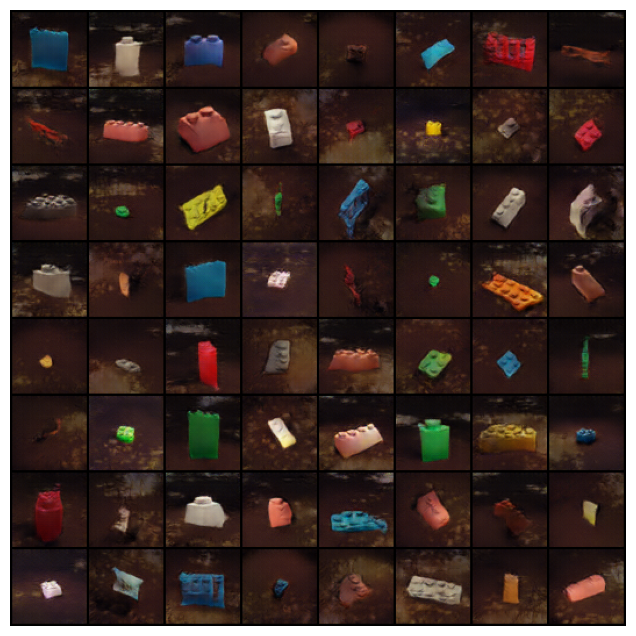

In [3]:
netG = Generator(ngpu)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.load_state_dict(torch.load(G_path))
netG.to(device)

# Hacky way of removing "module" from the state_dict when you train with nn.DataParallel
'''
state_dict = torch.load(G_path)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove module.
    new_state_dict[name] = v
netG.load_state_dict(new_state_dict)
netG.to(device)
'''

torch.manual_seed(manualSeed)
fake = netG(fixed_noise).detach().cpu()
imgs = vutils.make_grid(fake, padding=2, normalize=True)

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = plt.imshow(np.transpose(imgs,(1,2,0)), animated=True)
print("This should be the same image as the one in the training notebook")

Heres is 8 random legos and latents+0.5t for t in [0,7]


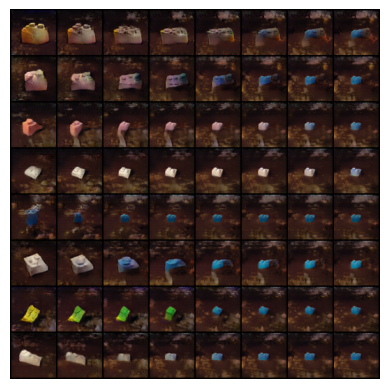

In [4]:
print("Heres is 8 random legos and latents+0.5t for t in [0,7]")
manualSeed = 69
torch.manual_seed(manualSeed)
noise = torch.randn(64, nz, 1, 1, device=device)

noise_list = []
steps = 8
for i in range(8):
    noise = torch.randn(1, nz, 1, 1, device=device)[0]
    for j in range(steps):
        noise_list.append(noise - 0.5*j)
noise = torch.stack(noise_list)

fake = latent_to_image(netG, noise)
img = vutils.make_grid(fake, padding=2, normalize=True)
plt.axis("off")
plt.imshow(np.transpose(img, (1,2,0)))
plt.show()

Here are the four random noise vectors that we will interpolate between


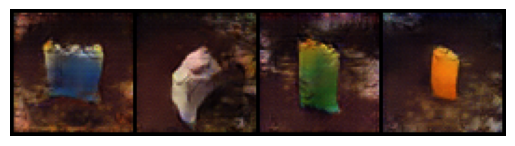

Here is the interpolation between the four noise vectors


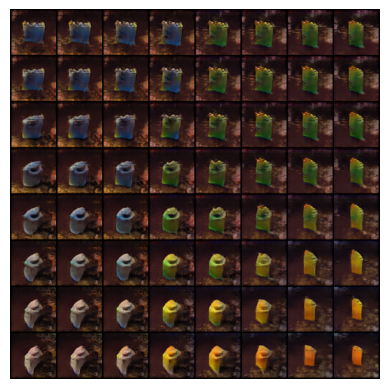

In [5]:
print("Here are the four random noise vectors that we will interpolate between")
torch.manual_seed(manualSeed)
noise = torch.randn(64, nz, 1, 1, device=device)
n1 = noise[0]
n2 = noise[23]
n3 = noise[42]
n4 = noise[62]
n1_2_3_4 = torch.stack([n1, n2, n3, n4])

fake = latent_to_image(netG, n1_2_3_4)
img = vutils.make_grid(fake, padding=2, normalize=True)
plt.axis("off")
plt.imshow(np.transpose(img, (1,2,0)))
plt.show()

print("Here is the interpolation between the four noise vectors")
steps = 8
interp1_2 = torch.stack([torch.lerp(n1, n2, i/(steps-1)) for i in range(steps)])
interp3_4 = torch.stack([torch.lerp(n3, n4, i/(steps-1)) for i in range(steps)])
l = []
for j in range(interp1_2.shape[0]):
    interp_step = torch.stack([torch.lerp(interp1_2[j], interp3_4[j], i/(steps-1)) for i in range(steps)])
    l.append(interp_step)
interp1_2_3_4 = torch.vstack(l)

# fake = netG(interp1_2_3_4).detach().cpu() # Gives inconsistent results
fake = latent_to_image(netG, interp1_2_3_4)
img = vutils.make_grid(fake, padding=2, normalize=True, nrow=8)
plt.axis("off")
plt.imshow(np.transpose(img, (1,2,0)))
plt.show()

In [6]:
def make_noise_images(seed, visualize=False):
  torch.manual_seed(seed)
  noise = torch.randn(64, nz, 1, 1, device=device)

  if visualize:
    fake = latent_to_image(netG, n1_2_3_4)
    img = vutils.make_grid(fake, padding=2, normalize=True)
    plt.axis("off")
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()
  
  return noise

def interpolate_between_each_noise(noise, steps):
  interpolations = []
  for j in range(len(noise) - 1):
    interp_step = torch.stack([torch.lerp(noise[j], noise[j + 1], i/(steps-1)) for i in range(steps)])
    interpolations.append(interp_step)

  return torch.vstack(interpolations)

def get_video_from_interpolations_forall_images(filename, frame_size=(64, 64), fps = 30):
  codec = cv2.VideoWriter_fourcc(*'mp4v')
  video_writer = cv2.VideoWriter(filename, codec, fps, frame_size)

  noise = make_noise_images(1)
  interp = interpolate_between_each_noise(noise, 100)
  fake = latent_to_image(netG, interp)

  for f in fake:
    img = vutils.make_grid(f, normalize=True)
    img = np.transpose(img, (1,2,0)).detach().numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img) * 255
    img = np.clip(img, 0, 255).astype(np.uint8)

    video_writer.write(img)

  video_writer.release()


get_video_from_interpolations_forall_images('gan_result.mp4')

In [7]:
# Failed thing with trying to interpolate between two noise vectors on one of the dimensions at a time
'''
torch.manual_seed(manualSeed)
noise = torch.randn(64, nz, 1, 1, device=device)
n1 = noise[1]
n2 = noise[5]
steps = 5
interp = torch.stack([torch.lerp(n1, n2, i/steps) for i in range(steps+1)])

for j in range(100):
    new_noise = torch.stack([n1 for _ in range(steps+1)])
    for i in range(steps+1):
        new_noise[i][j] = interp[i][j]

    new_noise = torch.cat((n1.unsqueeze(0), new_noise, n2.unsqueeze(0)), 0)
    fake = latent_to_image(netG, new_noise)
    img = vutils.make_grid(fake, padding=2, normalize=True, nrow=steps+3)
    plt.axis("off")
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()
'''

'\ntorch.manual_seed(manualSeed)\nnoise = torch.randn(64, nz, 1, 1, device=device)\nn1 = noise[1]\nn2 = noise[5]\nsteps = 5\ninterp = torch.stack([torch.lerp(n1, n2, i/steps) for i in range(steps+1)])\n\nfor j in range(100):\n    new_noise = torch.stack([n1 for _ in range(steps+1)])\n    for i in range(steps+1):\n        new_noise[i][j] = interp[i][j]\n\n    new_noise = torch.cat((n1.unsqueeze(0), new_noise, n2.unsqueeze(0)), 0)\n    fake = latent_to_image(netG, new_noise)\n    img = vutils.make_grid(fake, padding=2, normalize=True, nrow=steps+3)\n    plt.axis("off")\n    plt.imshow(np.transpose(img, (1,2,0)))\n    plt.show()\n'